In [1]:
######################
# Use Scrublet for Doublet Identification and prepare final anndata with all information 

##############
# Load libraries

In [2]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanorama
import os
import multiprocessing
import random
import time
import git
import sys
from datetime import date
from numpy import savetxt 
import scanpy.external as sce
import rpy2 as rpy2
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
import sklearn as sklearn

# Load Data

## Configurations

### Technical configurations

In [3]:
multiprocessing.cpu_count()  ### total amount of cpu on the used core

96

In [4]:
len(os.sched_getaffinity(0)) ### amount of available cpus

24

In [5]:
sc.settings.n_jobs   # default number of CPUs to use for parallel computing

1

In [6]:
sc.settings.max_memory  # maximum memory to use in GB

15

In [7]:
random.seed(7)

In [8]:
ncore = '24'

In [9]:
random_state_var = 0

In [10]:
n_jobs_var = 24

In [11]:
os.environ["OMP_NUM_THREADS"] = ncore
os.environ["OPENBLAS_NUM_THREADS"] = ncore
os.environ["MKL_NUM_THREADS"] = ncore
os.environ["VECLIB_MAXIMUM_THREADS"] = ncore
os.environ["NUMEXPR_NUM_THREADS"] = ncore

In [12]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 0

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                 8.3.1
annoy               NA
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2021.05.30
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           5.0.9
defusedxml       

In [13]:
file_name = 'A5_Scanpy_Scrublet_Doublet_Identification.ipynb'

In [14]:
repo = git.Repo('/home/icb/corinna.losert/projects/stark-stemi')

### Parameters

In [15]:
script_number = 'A5'

In [16]:
data_path = '../data/current'

In [17]:
data_path

'../data/current'

In [18]:
libraries = ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014'] # reduced to only 4 libraries for testing

In [19]:
libraries_text = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14']

In [20]:
libraries_dict = {'0001': 'L1', '0002': 'L2', '0003': 'L3', '0004': 'L4', '0005': 'L5',  '0006': 'L6', '0007': 'L7', '0008': 'L8', '0009': 'L9', '0010': 'L10', '0011': 'L11', '0012': 'L12', '0013': 'L13', '0014': 'L14'}

## Meta-Data File

In [21]:
path = data_path + "/preprocessed-data/meta-data/Mapping_Hashtag_Sample.csv"
library_hashtag_mapping = pd.read_csv(path) 
print('Last modified' + time.ctime(os.path.getmtime(path)))

Last modifiedThu Sep  2 13:17:03 2021


In [22]:
# library_hashtag_mapping

## Protein data from A1

In [23]:
anndata_dict_protein = dict.fromkeys(libraries_text)

In [24]:
for key in anndata_dict_protein:
    dataset_path = data_path + "/analysis/A/A1_" + key + '_protein_Final.h5ad'
    
    print(dataset_path)
    print('Last modified' + time.ctime(os.path.getmtime(dataset_path)))
        
    adata_orig = sc.read_h5ad(dataset_path)
    anndata_dict_protein[key]= adata_orig # save anndata in dictionary
    
    anndata_dict_protein[key].uns['data_load_time'] = time.ctime(os.path.getmtime(dataset_path))  # save the last modified timestamp of the data loaded
    anndata_dict_protein[key].uns['data_load_name'] = dataset_path # save the data path of the data loaded 
    

../data/current/analysis/A/A1_L1_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L2_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L3_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L4_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L5_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L6_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L7_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L8_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L9_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L10_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/current/analysis/A/A1_L11_protein_Final.h5ad
Last modifiedFri Jan 20 09:59:39 2023
../data/

## Demultiplexed data from A3

In [25]:
anndata_dict_demultiplexed = dict.fromkeys(libraries_text)

In [26]:
for key in anndata_dict_demultiplexed:
    dataset_path = data_path + "/analysis/A/A3_Processed_" + key + '_rna_Final.h5ad'
    
    print(dataset_path)
    print('Last modified' + time.ctime(os.path.getmtime(dataset_path)))
        
    adata_orig = sc.read_h5ad(dataset_path)
    adata_orig.var_names_make_unique()  # make variable names unique
    sc.pp.filter_genes(adata_orig, min_cells=1)  # filter genes
    
    anndata_dict_demultiplexed[key]= adata_orig # save anndata in dictionary
    
    anndata_dict_demultiplexed[key].uns['data_load_time'] = time.ctime(os.path.getmtime(dataset_path))  # save the last modified timestamp of the data loaded
    anndata_dict_demultiplexed[key].uns['data_load_name'] = dataset_path # save the data path of the data loaded 
    

../data/current/analysis/A/A3_Processed_L1_rna_Final.h5ad
Last modifiedFri Jan 20 10:44:57 2023
../data/current/analysis/A/A3_Processed_L2_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:04 2023
../data/current/analysis/A/A3_Processed_L3_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:10 2023
../data/current/analysis/A/A3_Processed_L4_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:17 2023
../data/current/analysis/A/A3_Processed_L5_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:24 2023
../data/current/analysis/A/A3_Processed_L6_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:32 2023
../data/current/analysis/A/A3_Processed_L7_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:38 2023
../data/current/analysis/A/A3_Processed_L8_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:46 2023
../data/current/analysis/A/A3_Processed_L9_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:52 2023
../data/current/analysis/A/A3_Processed_L10_rna_Final.h5ad
Last modifiedFri Jan 20 10:45:58 2023
../data/current/analysis/A/A3_Processed

In [27]:
### Short data check

In [28]:
anndata_dict_demultiplexed['L1']

AnnData object with n_obs × n_vars = 20572 × 24253
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'data_load_time', 'data_load_name'

In [29]:
anndata_dict_demultiplexed['L1'].X.sum(axis=1)

matrix([[6685.],
        [3167.],
        [7907.],
        ...,
        [4105.],
        [4064.],
        [7344.]])

## Add meta-data to demultiplexed data

In [30]:
#### Join meta info 

In [31]:
for key in anndata_dict_demultiplexed:
    anndata_dict_demultiplexed[key].obs['name'] = anndata_dict_demultiplexed[key].obs['HTO_classification_final']
    join_data = library_hashtag_mapping[library_hashtag_mapping['library'] == key]
    anndata_dict_index = anndata_dict_demultiplexed[key].obs.index
    anndata_dict_demultiplexed[key].obs = pd.merge(anndata_dict_demultiplexed[key].obs, join_data ,on='name',how='left') 
    anndata_dict_demultiplexed[key].obs.index = anndata_dict_index

/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [32]:
#### Check out joined information
anndata_dict_demultiplexed['L1'].obs

,nCount_HTO,nFeature_HTO,nCount_RNA,nFeature_RNA,percent_mt,HTO_maxID,HTO_secondID,HTO_margin,HTO_classification,HTO_classification.global,...,library,id,read,pattern,sequence,feature_type,Unnamed: 7,in_sample,display_name,group
AAACCCAAGTAGGAAG-1,414.0,7,6685.0,1696,7.240090,8.1,1.1,0.051745,1.1_8.1,Doublet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGTAGGGTC-1,226.0,7,3167.0,904,7.388696,9.1,5.1,0.464226,Negative,Negative,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACAAGAAATC-1,601.0,7,7907.0,1732,6.867333,1.1,2.1,0.704262,1.1_2.1,Doublet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACAATACGCT-1,8353.0,7,15367.0,3905,7.483569,2.1,8.1,3.892705,2.1_8.1,Doublet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCACACCACATA-1,833.0,7,7165.0,2130,6.322401,4.1,1.1,0.363664,1.1_4.1,Doublet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCACCTTAT-1,1120.0,7,7187.0,2480,6.024767,7.1,2.1,0.638372,2.1_7.1,Doublet,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCAGACTGT-1,353.0,7,4259.0,1261,5.541207,5.1,8.1,1.482897,5.1,Singlet,...,L1,HTO_B0255,R2,5PNNNNNNNNNN(BC),AAGTATCGTTTCGCA,Antibody Capture,NaN,1.0,5.1,TP1
TTTGTTGTCCGTAGGC-1,250.0,7,4105.0,1250,2.752741,7.1,5.1,1.618696,7.1,Singlet,...,L1,HTO_B0257,R2,5PNNNNNNNNNN(BC),TGTCTTTCCTGCCAG,Antibody Capture,NaN,1.0,7.1,TP1
TTTGTTGTCGGAGATG-1,488.0,7,4064.0,1185,5.585630,9.1,8.1,0.644727,9.1,Singlet,...,L1,HTO_B0259,R2,5PNNNNNNNNNN(BC),CAGTAGTCACGGTCA,Antibody Capture,NaN,1.0,9.1,TP1


In [33]:
#### Set data to use for further script 

In [34]:
anndata_dict = anndata_dict_demultiplexed

In [35]:
### Short data check

In [36]:
anndata_dict['L1']

AnnData object with n_obs × n_vars = 20572 × 24253
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'data_load_time', 'data_load_name'

In [37]:
anndata_dict['L1'].X.sum(axis=1)

matrix([[6685.],
        [3167.],
        [7907.],
        ...,
        [4105.],
        [4064.],
        [7344.]])

## Add meta-info + hasthag mapping to protein Data

In [38]:
### Join meta-info to protein-data

In [39]:
anndata_dict_protein

{'L1': AnnData object with n_obs × n_vars = 20572 × 10
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L2': AnnData object with n_obs × n_vars = 18667 × 8
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L3': AnnData object with n_obs × n_vars = 17837 × 7
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L4': AnnData object with n_obs × n_vars = 23187 × 10
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L5': AnnData object with n_obs × n_vars = 30388 × 10
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L6': AnnData object with n_obs × n_vars = 22541 × 10
     var: 'gene_ids', 'feature_types'

In [40]:
for key in anndata_dict_protein:
    anndata_dict_protein[key].obs = anndata_dict[key].obs ### TBD validate that cell-order stays the same!; check out other ways of joining

In [41]:
anndata_dict_protein

{'L1': AnnData object with n_obs × n_vars = 20572 × 10
     obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time', 'data_load_name'
     layers: 'counts',
 'L2': AnnData object with n_obs × n_vars = 18667 × 8
     obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
     uns: 'data_load_time

In [42]:
anndata_dict_protein['L1'].obs['HTO_classification.global']

AAACCCAAGTAGGAAG-1     Doublet
AAACCCAAGTAGGGTC-1    Negative
AAACCCACAAGAAATC-1     Doublet
AAACCCACAATACGCT-1     Doublet
AAACCCACACCACATA-1     Doublet
                        ...   
TTTGTTGTCACCTTAT-1     Doublet
TTTGTTGTCAGACTGT-1     Singlet
TTTGTTGTCCGTAGGC-1     Singlet
TTTGTTGTCGGAGATG-1     Singlet
TTTGTTGTCGTGGCGT-1     Doublet
Name: HTO_classification.global, Length: 20572, dtype: object

#############
# Processing and Doublet Identification

############# 
## Doublet identification on raw countdata with scrublet

In [43]:
#### Preparation - generate True/ False column from HTO demultiplex for comparison

for key in anndata_dict:
    anndata_dict[key].obs['HTO_Doublet_Classification'] =  anndata_dict[key].obs['HTO_classification.global']=='Doublet'

In [44]:
confusion_matrix_dict = {}  # create an empty dictionary for confusion matrix results

In [45]:
comparison_dict = {}

L1 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.84
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%

Predicted Doublets Info

Simulated Distribution


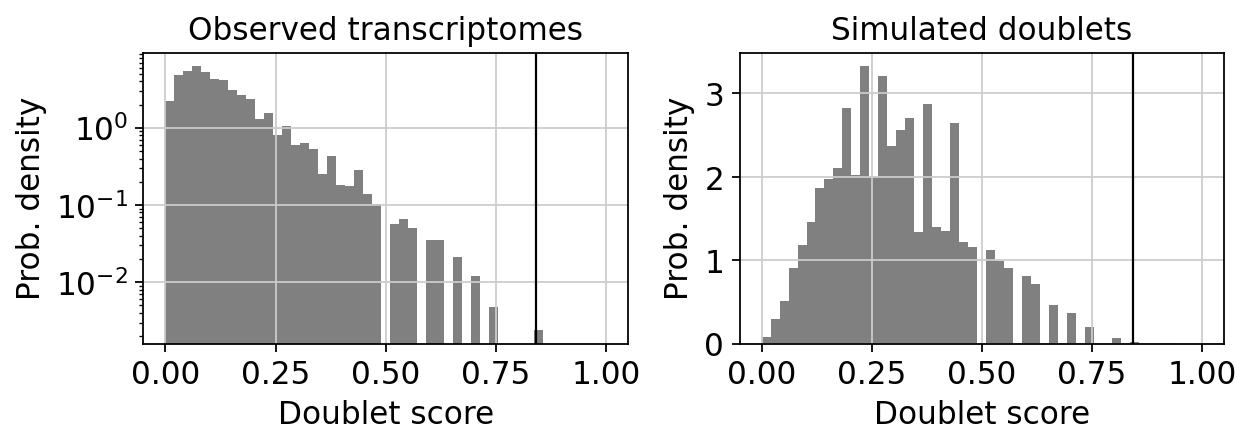


L1 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 5.4%
Estimated detectable doublet fraction = 44.2%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 12.3%

Predicted Doublets Info

Simulated Distribution


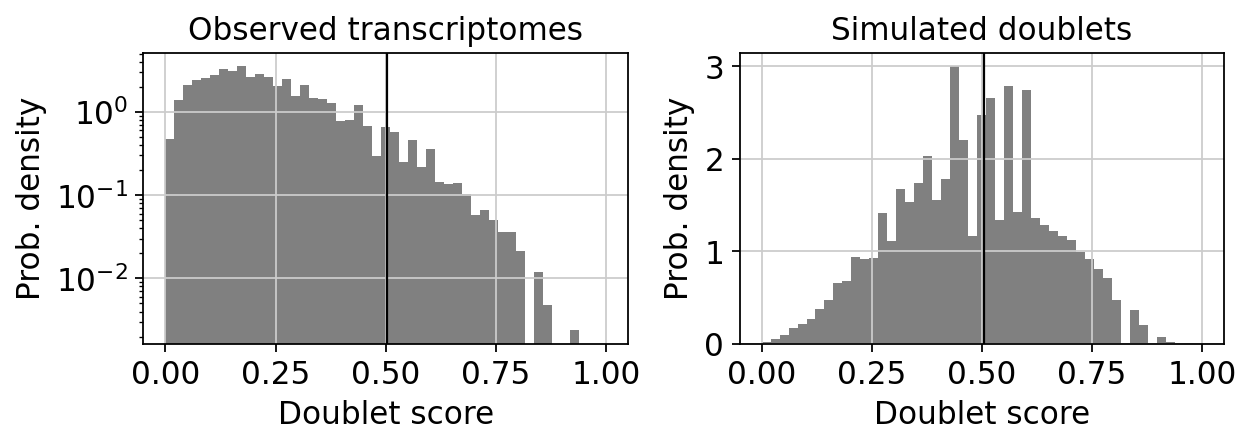


L2 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.82
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%

Predicted Doublets Info

Simulated Distribution


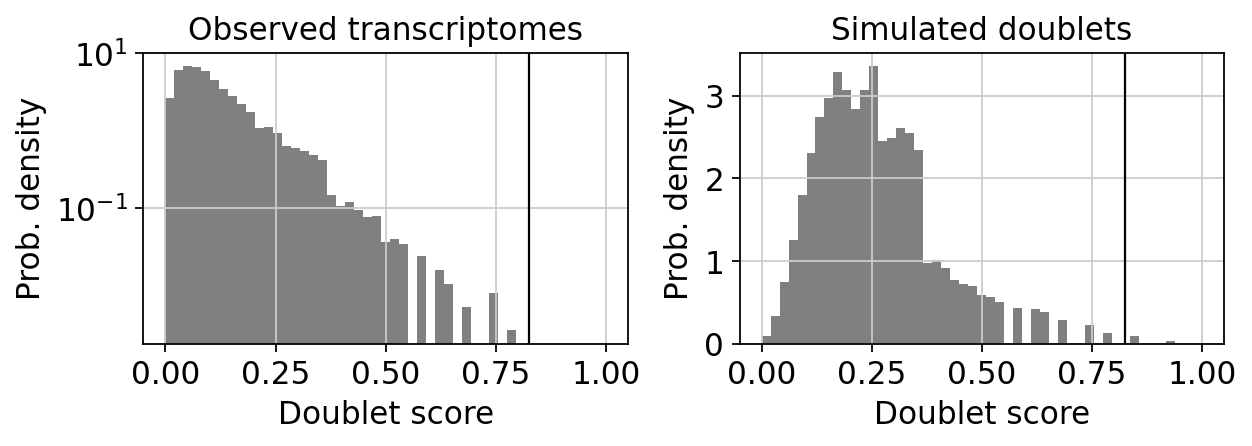


L2 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 8.3%
Estimated detectable doublet fraction = 47.8%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 17.5%

Predicted Doublets Info

Simulated Distribution


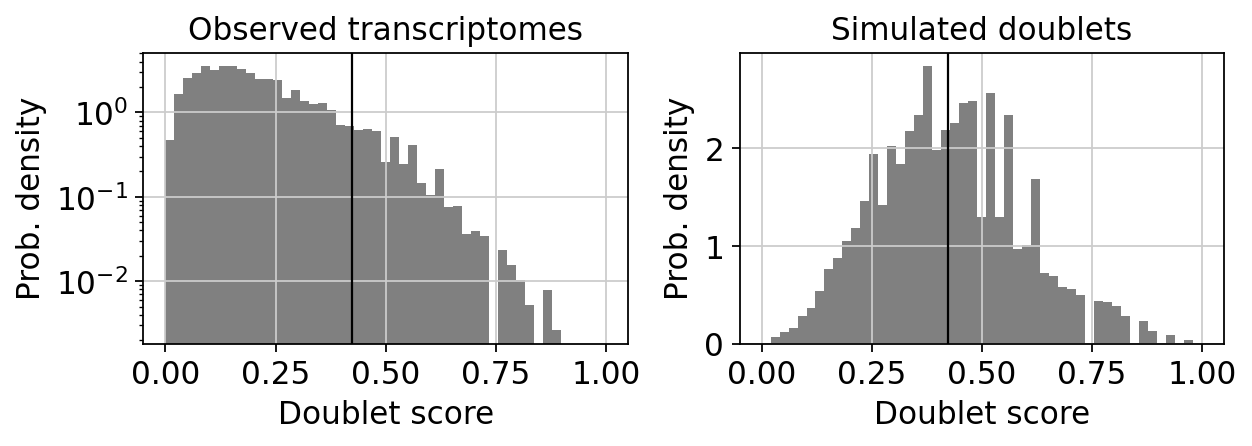


L3 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.83
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.8%

Predicted Doublets Info

Simulated Distribution


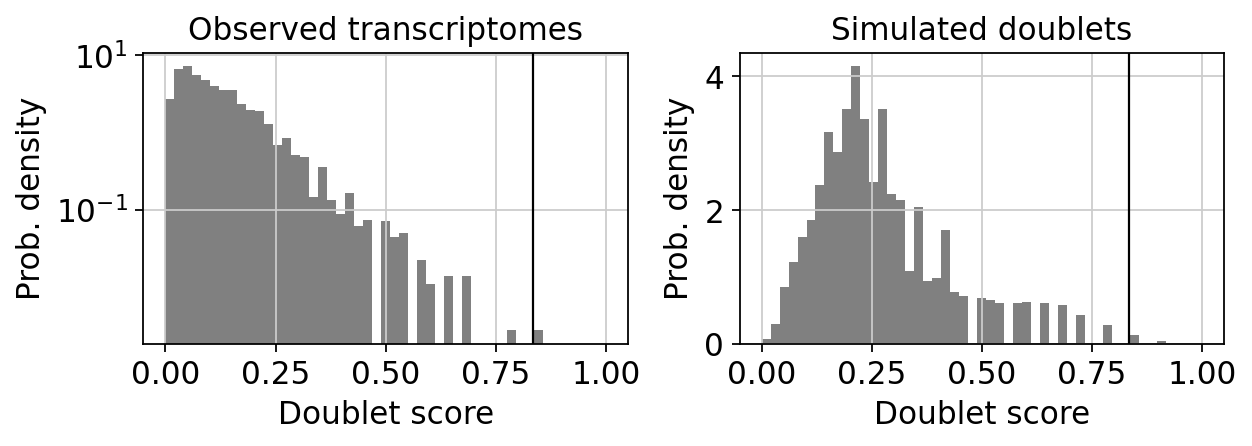


L3 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 14.1%
Estimated detectable doublet fraction = 63.7%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 22.2%

Predicted Doublets Info

Simulated Distribution


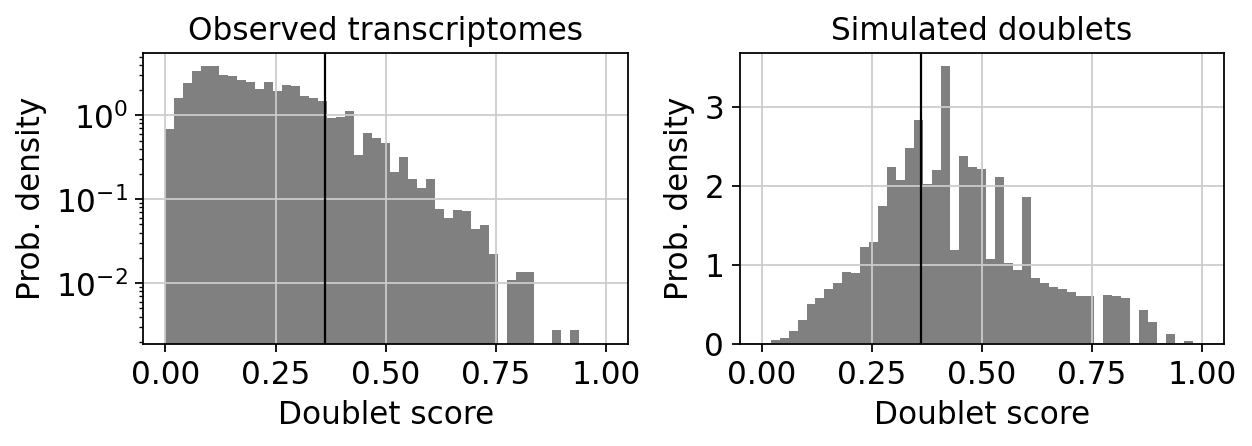


L4 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.85
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%

Predicted Doublets Info

Simulated Distribution


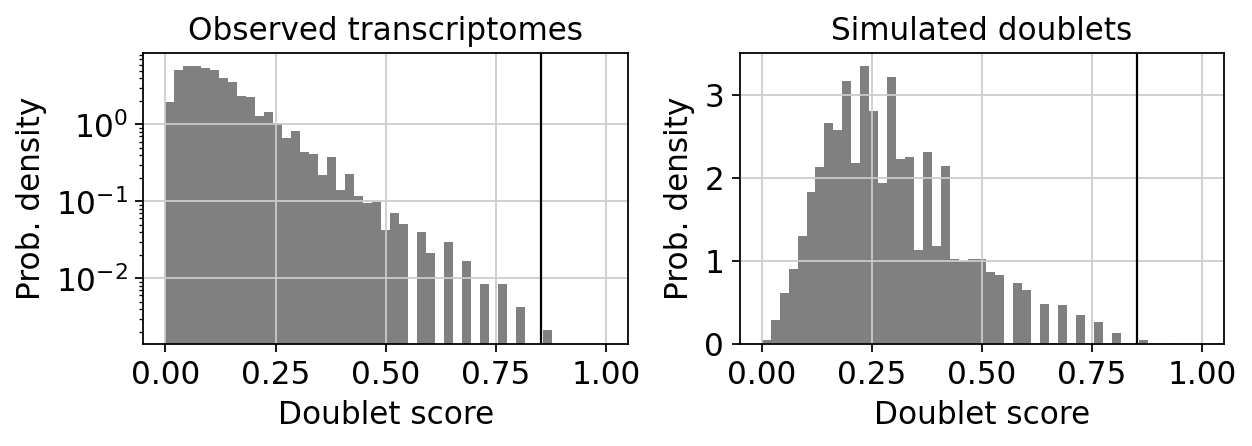


L4 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.46
Detected doublet rate = 7.3%
Estimated detectable doublet fraction = 49.4%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 14.7%

Predicted Doublets Info

Simulated Distribution


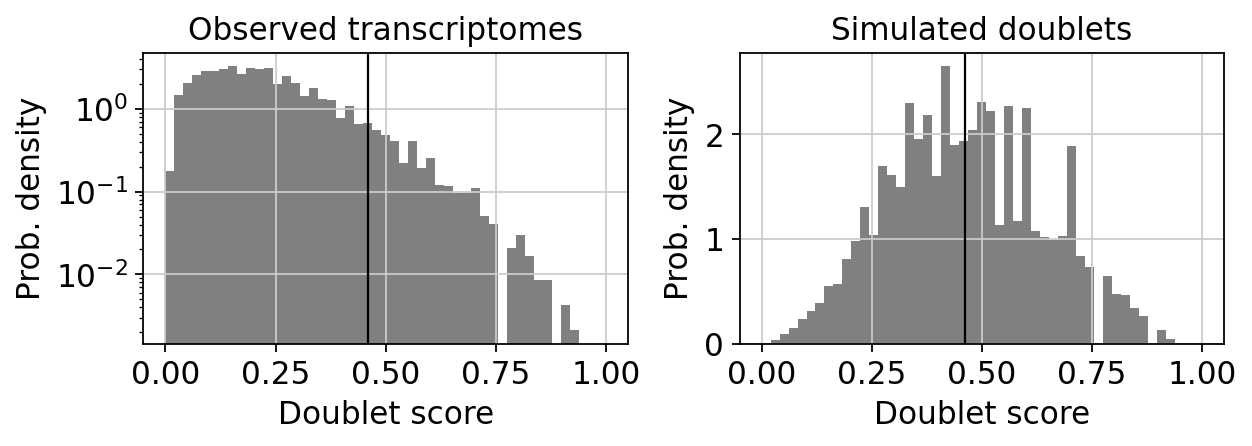


L5 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.82
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%

Predicted Doublets Info

Simulated Distribution


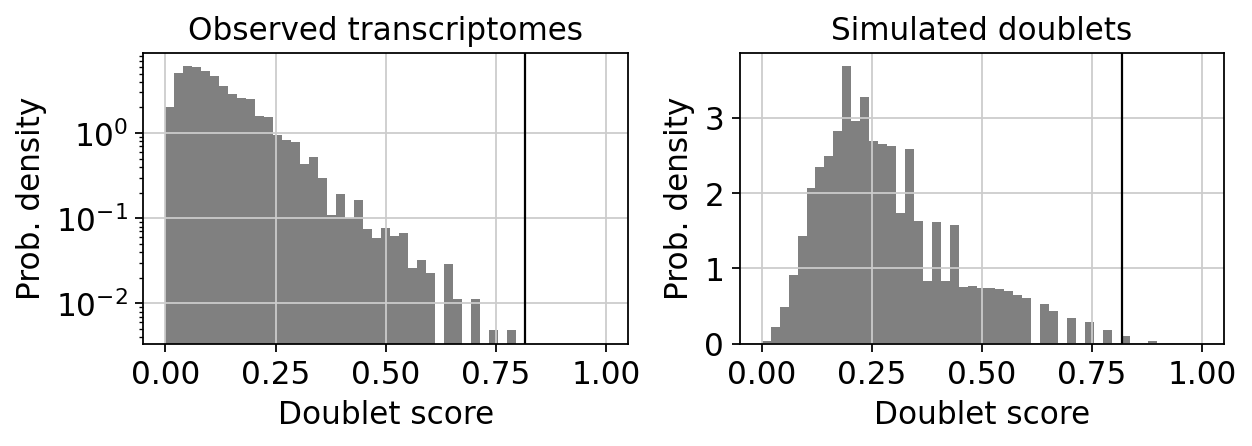


L5 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 12.3%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 5.8%

Predicted Doublets Info

Simulated Distribution


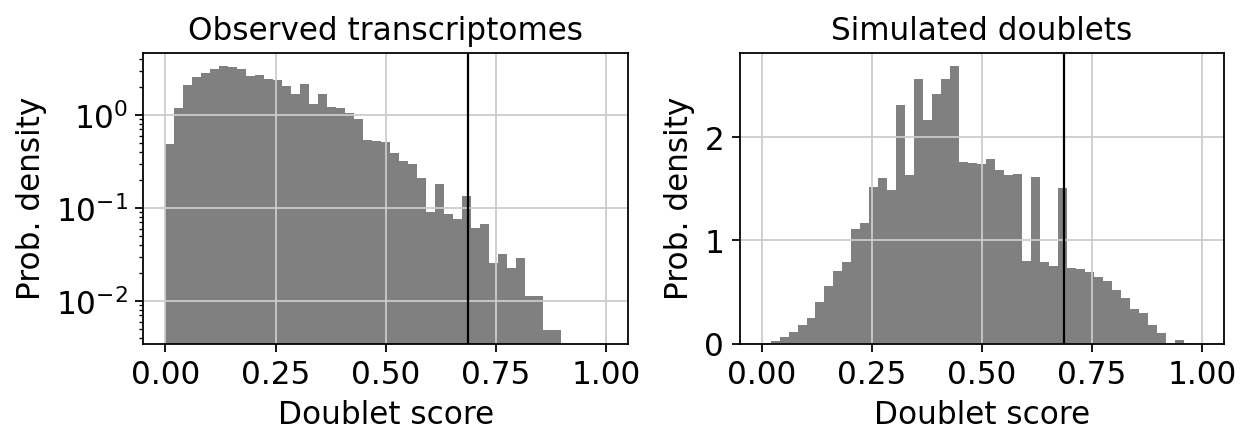


L6 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.84
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%

Predicted Doublets Info

Simulated Distribution


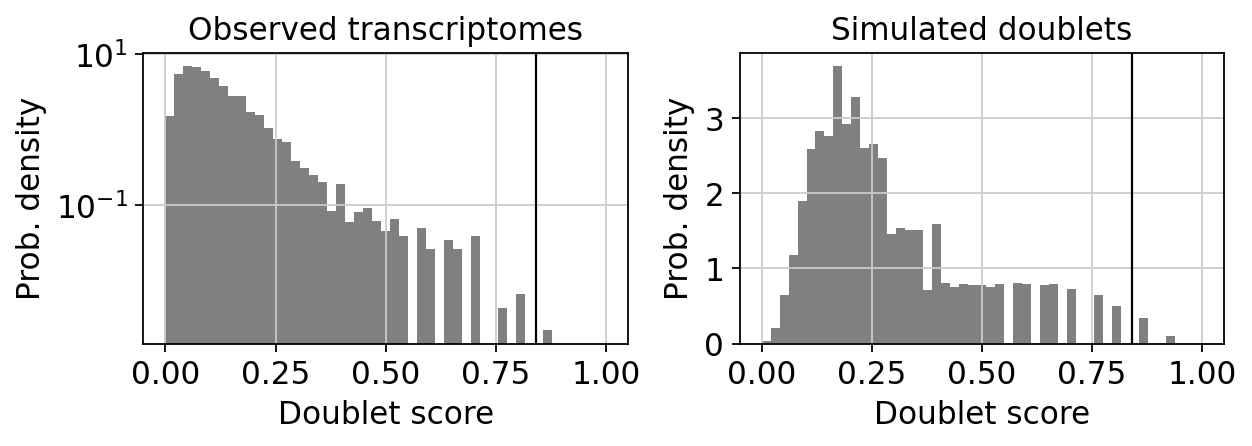


L6 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 25.5%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 6.6%

Predicted Doublets Info

Simulated Distribution


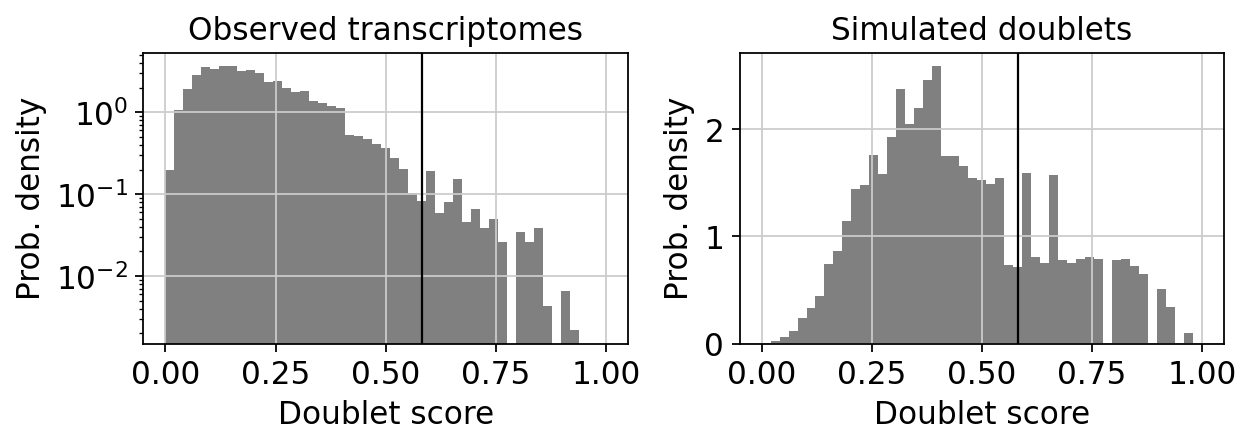


L7 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.83
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%

Predicted Doublets Info

Simulated Distribution


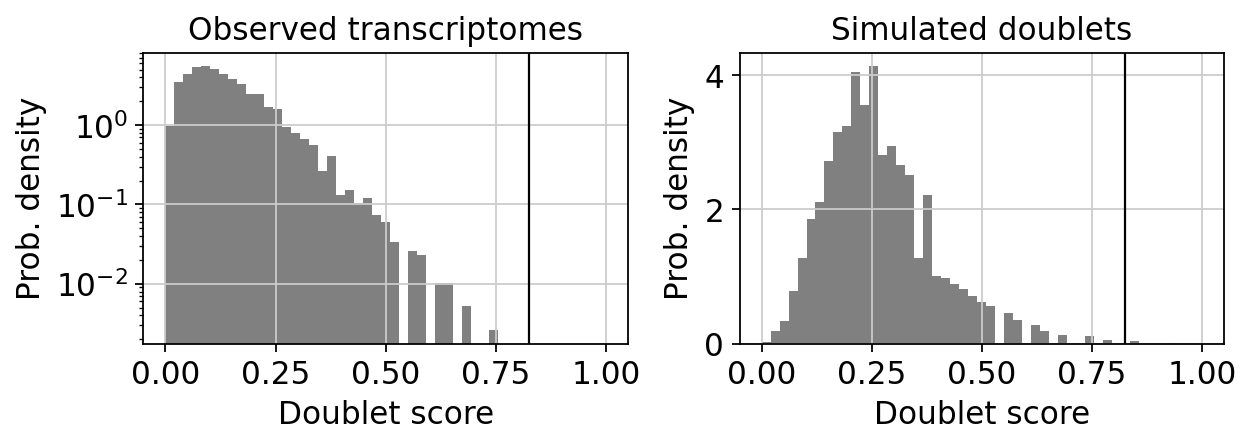


L7 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 9.0%
Estimated detectable doublet fraction = 44.1%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 20.4%

Predicted Doublets Info

Simulated Distribution


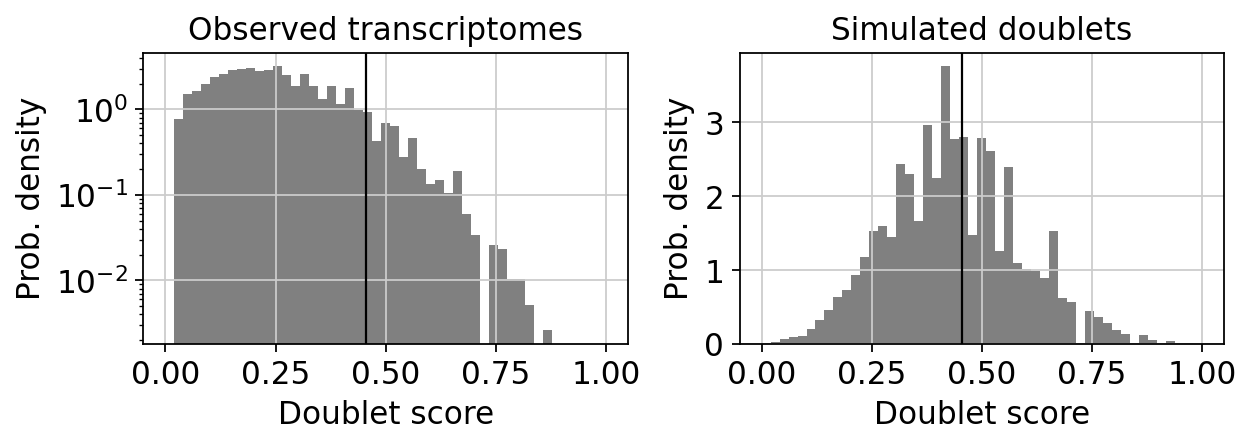


L8 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.85
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.2%

Predicted Doublets Info

Simulated Distribution


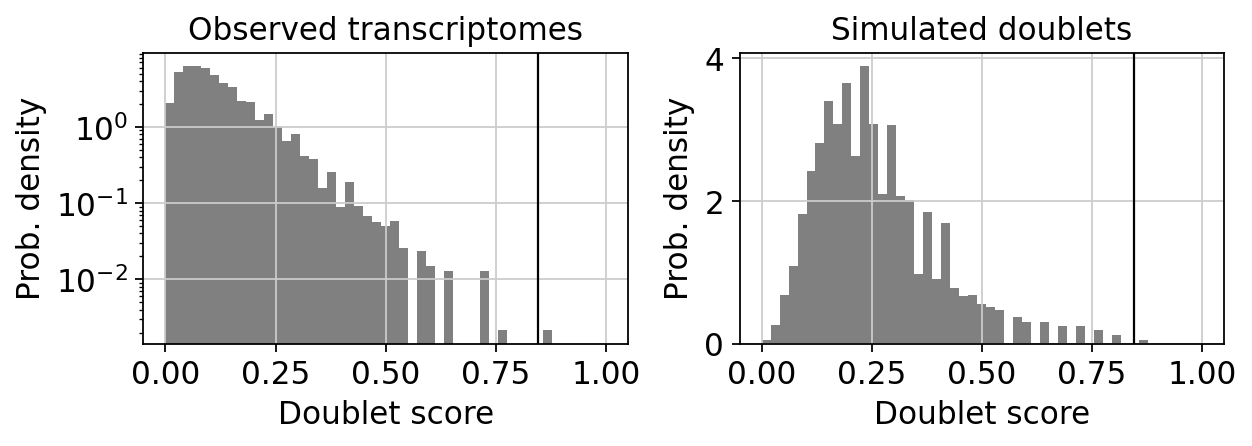


L8 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 7.4%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 17.1%

Predicted Doublets Info

Simulated Distribution


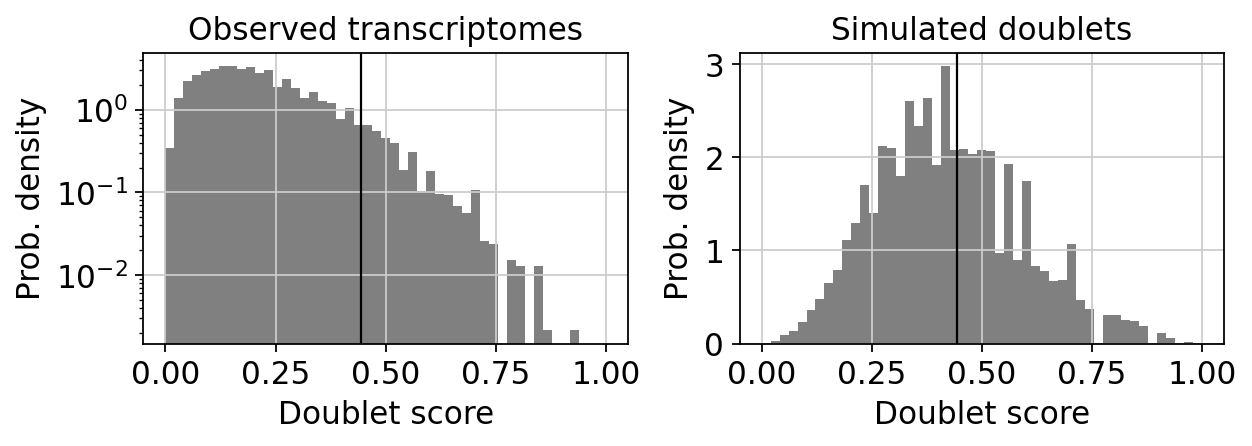


L9 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.83
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.3%

Predicted Doublets Info

Simulated Distribution


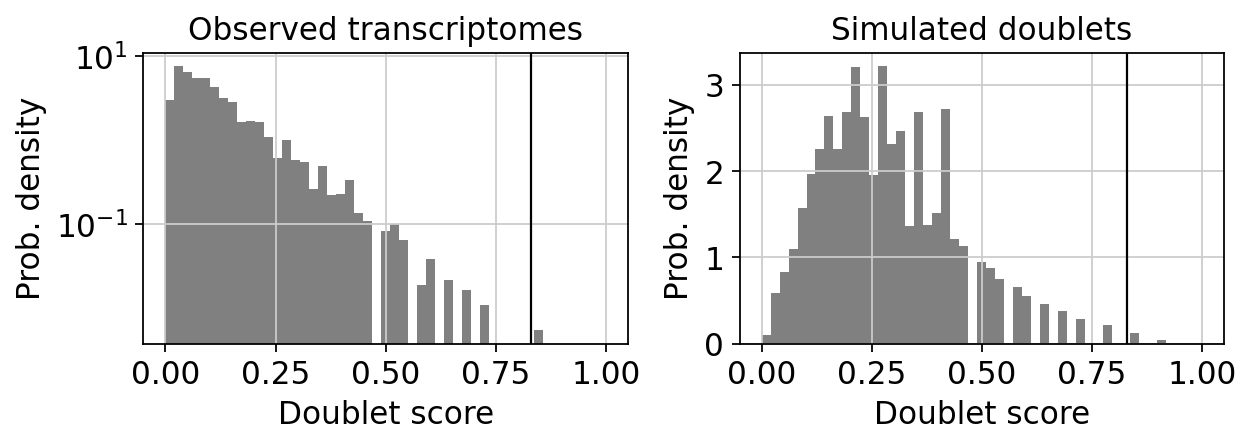


L9 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 6.0%
Estimated detectable doublet fraction = 42.7%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 14.0%

Predicted Doublets Info

Simulated Distribution


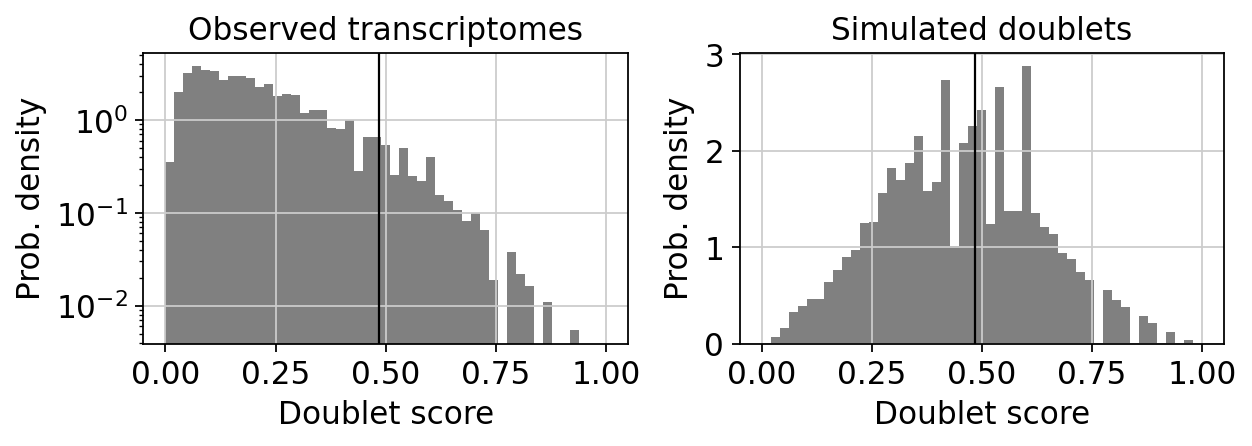


L10 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.84
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%

Predicted Doublets Info

Simulated Distribution


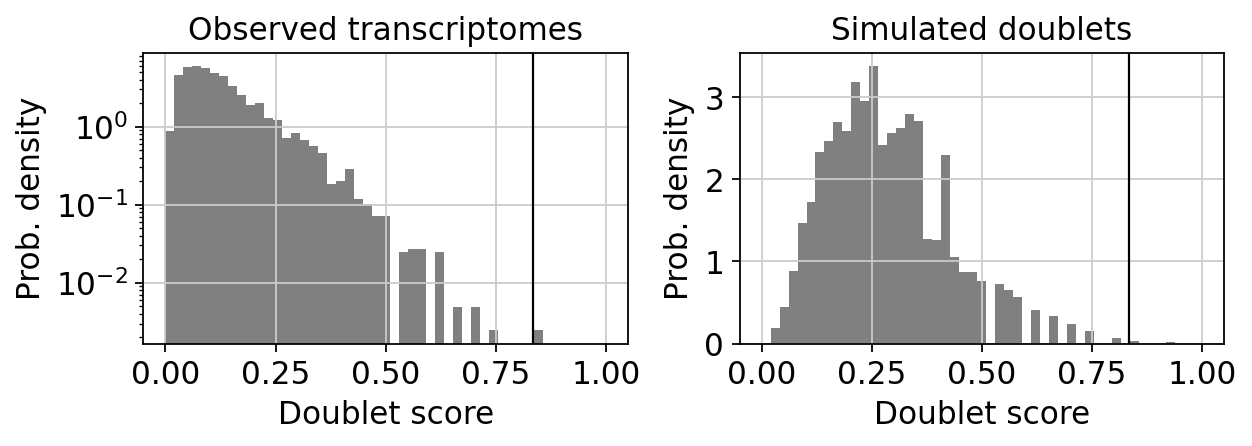


L10 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 5.1%
Estimated detectable doublet fraction = 37.6%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 13.5%

Predicted Doublets Info

Simulated Distribution


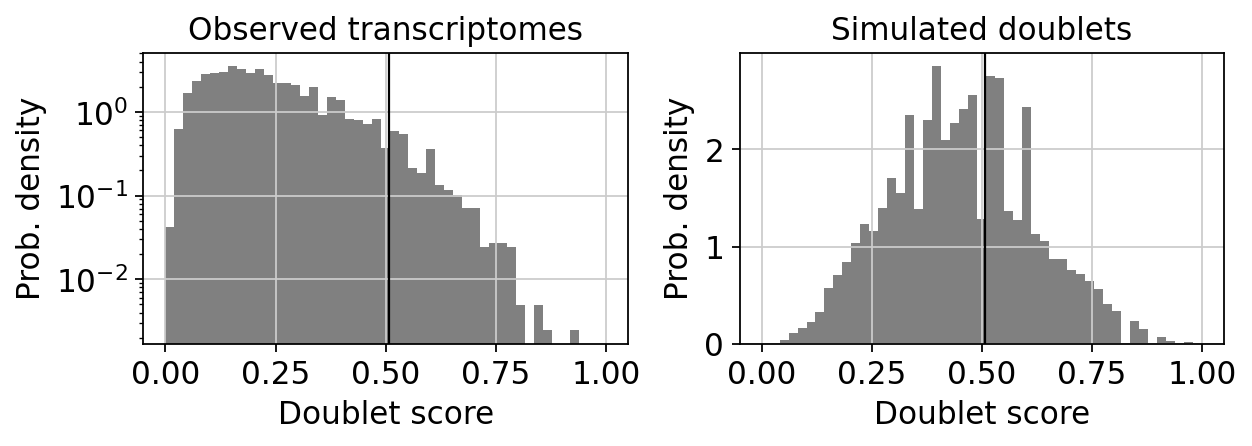


L11 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 6.5%
Estimated detectable doublet fraction = 50.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.9%

Predicted Doublets Info

Simulated Distribution


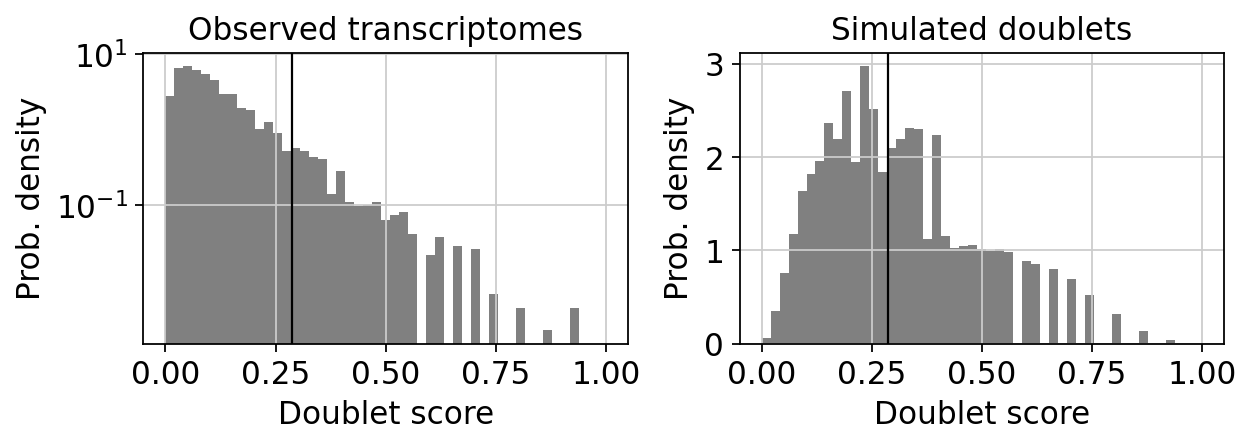


L11 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 8.8%
Estimated detectable doublet fraction = 57.8%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 15.2%

Predicted Doublets Info

Simulated Distribution


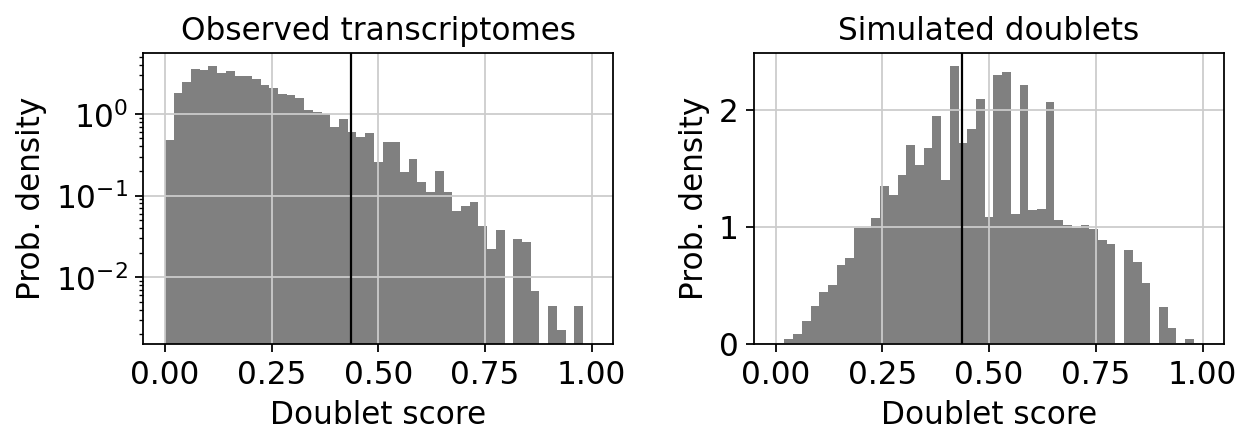


L12 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 5.5%
Estimated detectable doublet fraction = 49.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.0%

Predicted Doublets Info

Simulated Distribution


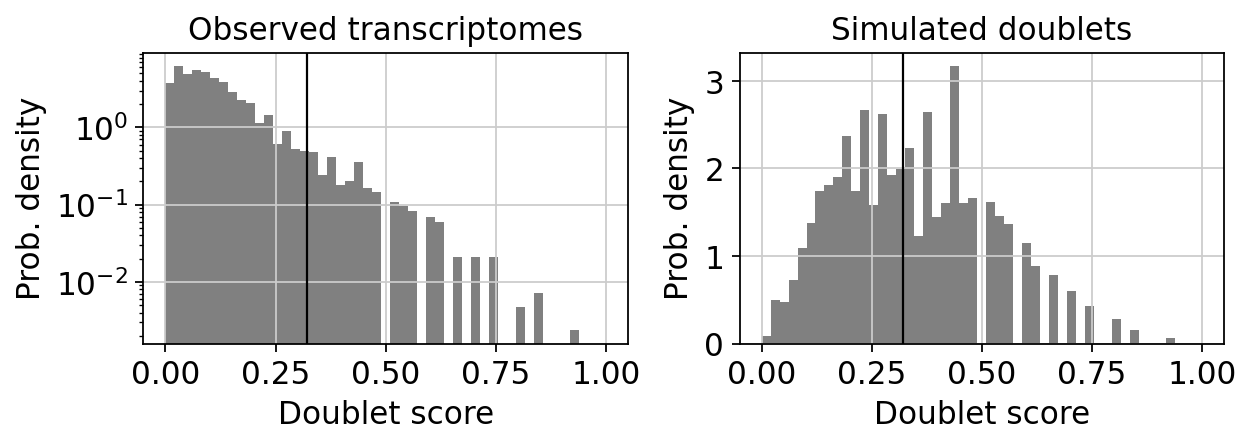


L13 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.88
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%

Predicted Doublets Info

Simulated Distribution


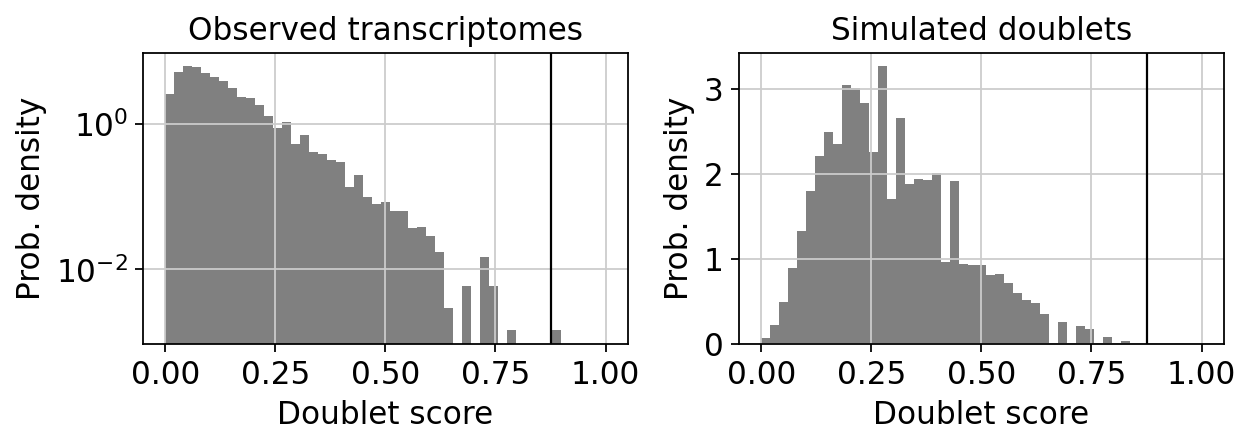


L13 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 4.6%
Estimated detectable doublet fraction = 37.6%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 12.3%

Predicted Doublets Info

Simulated Distribution


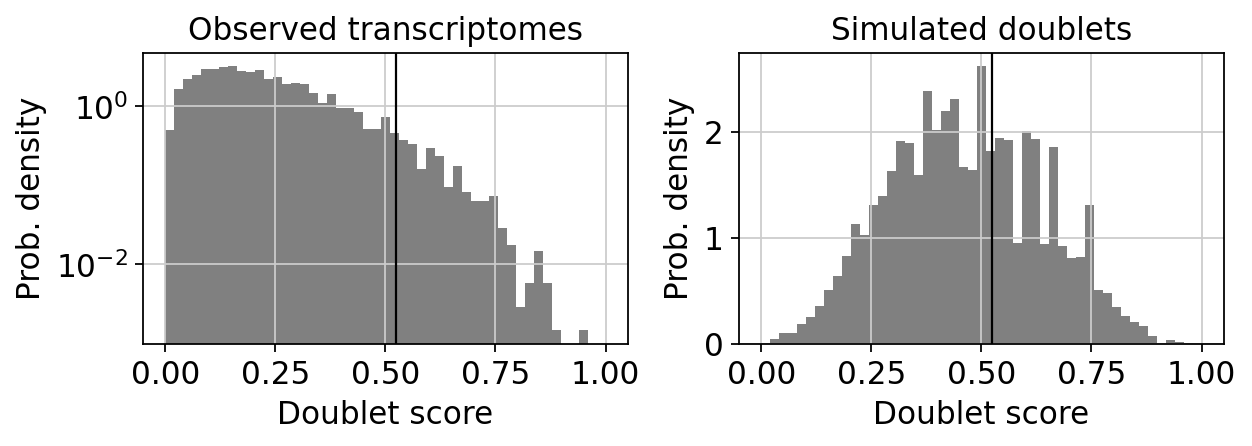


L14 0.1

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%

Predicted Doublets Info

Simulated Distribution


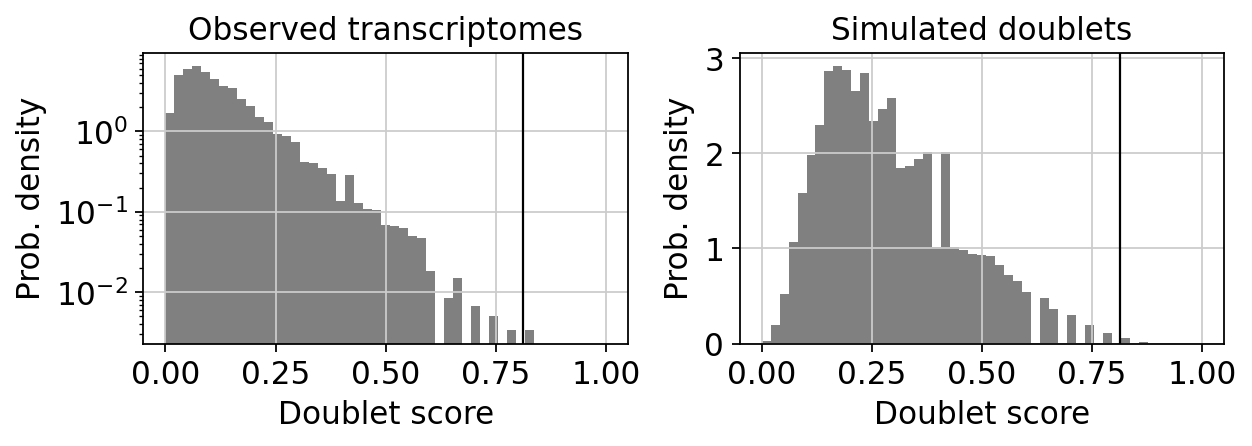


L14 0.2

Scrublet Algorithm Info
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 13.2%
Estimated detectable doublet fraction = 61.2%
Overall doublet rate:
	Expected   = 20.0%
	Estimated  = 21.5%

Predicted Doublets Info

Simulated Distribution


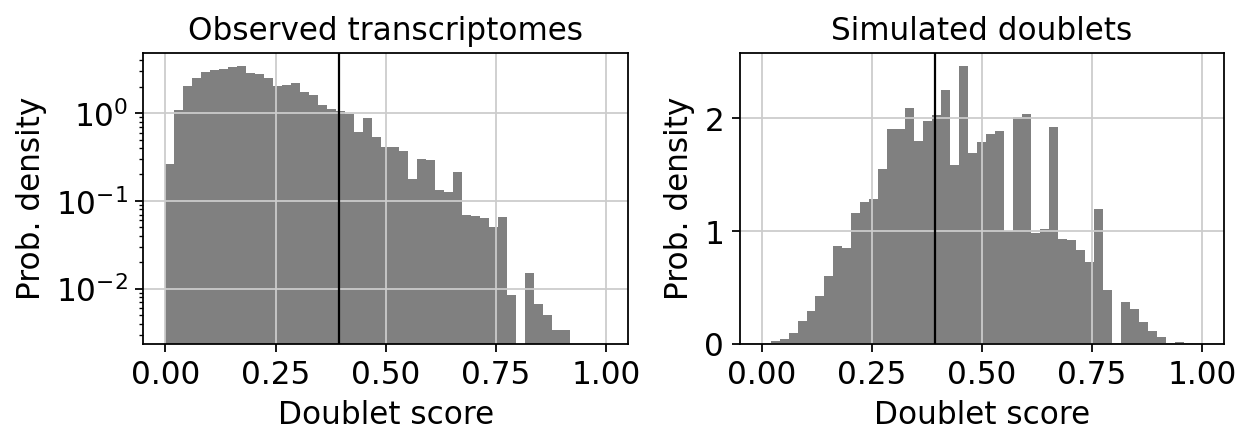

In [46]:
#### Calculate doublets with different thresholds


for key in anndata_dict:
    thres =  [0.1, 0.2]
    for threshold in thres:
        if (key != 'L12' or threshold != 0.2):   # somehow this combination of threshold and key does not seem to work
            threshold_str = str(threshold)
            print(key + ' ' + threshold_str)
            print('')

            print('Scrublet Algorithm Info')
            sce.pp.scrublet(anndata_dict[key], log_transform = True, expected_doublet_rate = threshold, random_state = random_state_var)
            print('')

            print('Predicted Doublets Info')
            anndata_dict[key].obs['predicted_doublet'].value_counts()  # get the amount of predicted doublets True/ False
            print('')

            confusion_matrix =  pd.DataFrame(sklearn.metrics.confusion_matrix(anndata_dict[key].obs['HTO_Doublet_Classification'], anndata_dict[key].obs['predicted_doublet']))
            confusion_matrix = confusion_matrix.rename(index = {0:'HTO-False', 1:'HTO-True'})  # rename entries in confustion matrix
            confusion_matrix = confusion_matrix.rename(columns= {0:'Scrublet-False', 1:'Scrublet-True'})
            confusion_matrix_dict[key+threshold_str] = confusion_matrix

            ### compare to HTO demultiplex doublet prediction
            comparison_dict[key+threshold_str] = anndata_dict[key].obs.groupby('HTO_classification.global').mean()

            #### Plot the distribution
            print('Simulated Distribution')
            sce.pl.scrublet_score_distribution(anndata_dict[key])
            print('')

            #### Save the predictions 
            anndata_dict[key].obs[script_number + '_scrublet_predicted_doublet_lib'+threshold_str] =  anndata_dict[key].obs['predicted_doublet']  # save predicted 
            anndata_dict[key].obs[script_number+'_scrublet_doublet_score_lib_'+threshold_str] = anndata_dict[key].obs['doublet_score']  # save predicted 

In [47]:
#### Choose thresholds and final doublet score (TBD maybe make more elaborated - to choose different threshold for each lib)

In [48]:
for key in anndata_dict:
    print(key)
    if (key != 'L12'):
        anndata_dict[key].obs[script_number + '_scrublet_predicted_doublet_lib'] =  anndata_dict[key].obs['A5_scrublet_predicted_doublet_lib0.2']  # save predicted 
        anndata_dict[key].obs[script_number + '_scrublet_doublet_score_lib'] = anndata_dict[key].obs['A5_scrublet_doublet_score_lib_0.2']  # save predicted 
    else:
        anndata_dict[key].obs[script_number + '_scrublet_predicted_doublet_lib'] =  anndata_dict[key].obs['A5_scrublet_predicted_doublet_lib0.1']  # save predicted 
        anndata_dict[key].obs[script_number + '_scrublet_doublet_score_lib'] = anndata_dict[key].obs['A5_scrublet_doublet_score_lib_0.1']  # save predicted 

L1
L2
L3
L4
L5
L6
L7
L8
L9
L10
L11
L12
L13
L14


In [49]:
# confusion_matrix_dict

In [50]:
# comparison_dict

In [51]:
anndata_dict['L1']

AnnData object with n_obs × n_vars = 20572 × 24253
    obs: 'nCount_HTO', 'nFeature_HTO', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'HTO_classification_final', 'name', 'library', 'id', 'read', 'pattern', 'sequence', 'feature_type', 'Unnamed: 7', 'in_sample', 'display_name', 'group', 'HTO_Doublet_Classification', 'doublet_score', 'predicted_doublet', 'A5_scrublet_predicted_doublet_lib0.1', 'A5_scrublet_doublet_score_lib_0.1', 'A5_scrublet_predicted_doublet_lib0.2', 'A5_scrublet_doublet_score_lib_0.2', 'A5_scrublet_predicted_doublet_lib', 'A5_scrublet_doublet_score_lib'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'data_load_time', 'data_load_name', 'scrublet'

# Save the added doublet information

In [52]:
for key in anndata_dict:
    print(key)
    data_name = data_path + '/analysis/A/' +  'A5_Processed_' + key + '_rna_Final.h5ad'
    
    print(data_name)
    print('Last modified' + date.today().strftime("%m/%d/%Y, %H:%M:%S"))
    
    anndata_dict[key].uns['data_save_time'] = date.today().strftime("%m/%d/%Y, %H:%M:%S") # save the last modified timestamp of the data saved
    anndata_dict[key].uns['data_save_name'] = data_name # save the data path of the data loaded 
    
    working_directory = os.getcwd()
    repo.index.add([working_directory + '/' + file_name])
    commit = repo.index.commit('Save data '+ data_name + ' '+ date.today().strftime("%m/%d/%Y, %H:%M:%S") )
    print(commit)
    
    anndata_dict[key].write(data_name)
    

L1
../data/current/analysis/A/A5_Processed_L1_rna_Final.h5ad
Last modified01/20/2023, 00:00:00


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical


bf02f1ba5d2aa160478789f1a08bac5d425e7389


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_classification' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_classification.global' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: Fu

L2
../data/current/analysis/A/A5_Processed_L2_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
bd7e488d3d467d9d9bd35f4025cffe634d126ac1
L3
../data/current/analysis/A/A5_Processed_L3_rna_Final.h5ad
Last modified01/20/2023, 00:00:00


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

7e3538fb57d603f543375451e31bdc040a376a90


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L4
../data/current/analysis/A/A5_Processed_L4_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
c1ca38d6b9e3fcfe90692f0c893bd2b5fadaa81e


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L5
../data/current/analysis/A/A5_Processed_L5_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
3aec814f64555af0c918669d72b35b8cc7d1d5c3


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L6
../data/current/analysis/A/A5_Processed_L6_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
10a4f5ccbc3f642ca5849aaaba4b04cd6b3d4d93


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L7
../data/current/analysis/A/A5_Processed_L7_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
575f1def66cbb8604f70710c6bee2184a0a7fb8c


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L8
../data/current/analysis/A/A5_Processed_L8_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
35a37ec45ab0e52a9eea849b917afffca1a377f1
L9
../data/current/analysis/A/A5_Processed_L9_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
a76c4636abd661d97eeba920e9d3eb0eca32b54e


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L10
../data/current/analysis/A/A5_Processed_L10_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
f634c03cc7531a165f79227934da5ee2b85d0527


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L11
../data/current/analysis/A/A5_Processed_L11_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
78d31f65e798853e9bb5aa0342ee8351fe96b476


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sequence' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_type' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpla

L12
../data/current/analysis/A/A5_Processed_L12_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
db7f9f73804a3c30dc51aa6b4a55588076e43b06


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_maxID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'HTO_secondID' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inpl

L13
../data/current/analysis/A/A5_Processed_L13_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
dd250718cd316a7d5aebeccf887f524e3d102eda


/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'library' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'id' as categorical
/home/icb/corinna.losert/miniconda3/envs/stark_stemi_Python/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` paramet

L14
../data/current/analysis/A/A5_Processed_L14_rna_Final.h5ad
Last modified01/20/2023, 00:00:00
326ab6b744f2caa1c98193f95386cf54715ccd9e
